Ressources:
- https://realpython.com/api-integration-in-python/
- https://realpython.com/python-requests/

In [1]:
import requests
from requests.auth import HTTPBasicAuth
from requests import Session
from zipfile import ZipFile
from io import BytesIO
from os import environ
from pathlib import Path
from collections import defaultdict
import yaml
import json
from IPython.display import JSON

%matplotlib inline

# Configuration, creedentials

In [2]:


class Config(defaultdict):
    """
    Set and save creedentials for IoT services creedentials
    
    IoT suite composed of RemoteManager, Things, Rollouts, Permissions,
    Insights, Analytics, Hub
    
    """
    default: str=f"{environ['HOME']}/.iot.yml"
    # does not work with defaultdict
    __slots__ = ['_yaml','RemoteManager', 'Things','Rollouts', 'Permissions',
                 'Insights', 'Analytics', 'Hub']
    
    def __init__(self, filename=None):
        # Init defaultdict as dict of dict
        super().__init__(dict)
        self._yaml = Path(filename if filename else self.default)
        
        # Read the file and update self if it exists
        if self._yaml.exists():
            self.update(yaml.safe_load(self._yaml.read_text()))
        
        self._remove_underscored_keys()
        
    def _remove_underscored_keys(self):
        keys = list(filter(lambda k: k.startswith('_'), self.keys()))
        for key in keys:
            del self[key]
        
    def __getattr__(self, attr):
        return self[attr]
        
    def add(self, service, name, creedentials):
        """
    
        """
        # Add creedentials
        self[service][name] = creedentials
        self._remove_underscored_keys()

        cfg._yaml.write_text(yaml.dump(dict(self)))
        # make it a little less dirty: 
        # change file permissions to 600
        cfg._yaml.chmod(0o600)

In [3]:
cfg = Config()

## Select instance name

In [4]:
# Named my insights instance 'xxx'
instance_name = "xxx"
# dirty hack: update globals with creedentials keys
# 'service_url', 'dashboard_url', 'data_recorder_url', 'project', 'username', 'password'
globals().update(cfg.Insights[instance_name])

# Session

## Authentication

Basic authentication first

In [5]:
auth = HTTPBasicAuth(username, password)

Create the `Session`

In [6]:
s = Session()
s.auth = auth

# sets cookie
s.get(service_url)

<Response [200]>

## Cookie

According the [documentation](https://bosch-iot-insights.com/static-contents/docu/html/sfde-cloud-user-guide.html#_cookies), one Cookie called XSRF-TOKEN needs special care. Its purpose is to protect against Cross-Site-Request-Forgery. The content value of this Cookie needs to be sent in a HTTP Header called X-XSRF-TOKEN on all subsequent requests!

Look at it:

In [7]:
s.cookies.keys()

['JSESSIONID', 'XSRF-TOKEN', 'ARRAffinity', '__VCAP_ID__', 'styleId']

Put it in the headers

In [8]:
s.headers['X-XSRF-TOKEN'] = s.cookies.get('XSRF-TOKEN')

# Quick Intro

This quick intro is described in the [sFDE cloud user guide](https://bosch-iot-insights.com/static-contents/docu/html/sfde-cloud-user-guide.html)

In [9]:
watermeter = s.get("https://bosch-iot-insights.com/static-contents/docu/watermeter_201807.zip")
myzipfile = ZipFile(BytesIO(watermeter.content))
watermeter_201807 = json.loads(myzipfile.open(myzipfile.filelist[0]).read().decode())

> if getting a `status_code` of 403 or such a window, e.g. for [HTTP Data Recorder Service](https://bosch-iot-insights.com/data-recorder-service), plese check the user autorization at https://bosch-iot-insights.com/ui/project/PROJECT_NUMBER/admin/users


![Not allowed...](img/Sorry.png)

One can get the documentation for `POST` operations [here](https://bosch-iot-insights.com/data-recorder-service/swagger-ui.html#!/Data45Recorder45Service/receiveDataUsingPOST)

## Post data

In [10]:
with Session() as s:
    s.auth = HTTPBasicAuth(username, password)
    s.get(service_url)
    s.headers['X-XSRF-TOKEN'] = s.cookies.get('XSRF-TOKEN')
    s.headers['Content-Type'] = 'application/json;charset=UTF-8'

    url2 = f'https://bosch-iot-insights.com/data-recorder-service/v2/{project}'
    r2 = s.post(url2, auth=auth, data=json.dumps(watermeter_201807))

In [11]:
url3 = f'https://bosch-iot-insights.com/mongodb-query-service/v2/{project}/collections'
r3 = s.get(url3)

In [12]:
r3.status_code

200

In [13]:
collection = json.loads(r3.content.decode())[0]['name']

# Query

In [14]:
query = {
    "collection": f"{collection}",
    "query": [{
        "$match": {
            "payload.measurements.timestamp": {
                "$gte": {
                    "$date": "2018-06-30T22:00:00.000Z"
                },
                "$lte": {
                    "$date": "2018-07-30T22:00:00.000Z"
                }
            }
        }
    }]
}

In [15]:
with Session() as s:
    s.auth = HTTPBasicAuth(username, password)
    s.get(service_url)
    s.headers['X-XSRF-TOKEN'] = s.cookies.get('XSRF-TOKEN')
    s.headers['Content-Type'] = 'application/json;charset=UTF-8'

    url5 = f"https://bosch-iot-insights.com/mongodb-query-service/v2/{project}/execute-aggregation-query"
    r5 = s.post(url5, data=json.dumps(query))

# Display that

In [16]:
from pandas import DataFrame
import pandas as pd

In [17]:
data = json.loads(r5.content)

In [18]:
JSON(data)

<IPython.core.display.JSON object>

In [19]:
mydateparser = lambda x: pd.datetime.strptime(x, "%Y-%m-%dT%H:%M:%SZ")

In [20]:
df = DataFrame(data[0]['payload']['measurements'])

In [21]:
df.sample()

,meter,timestamp,value
4530,Flat 1,{'$date': '2018-07-21T08:50:39Z'},4.75


In [22]:
ts = df.timestamp

In [23]:
df.index = ts.apply(lambda x: mydateparser(x['$date']))

In [24]:
import matplotlib.pyplot as plt

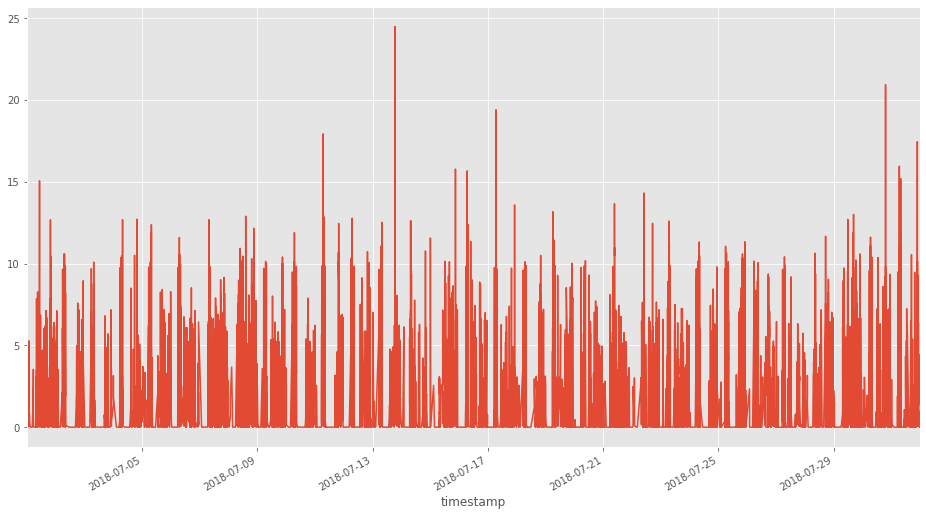

In [25]:
with plt.style.context('ggplot'):
    df.value.plot(figsize=(16,9))